**Lab1: "Метод обратного распространения ошибки"**

Выполнила: Яшина Дарья

In [2]:
!pip install idx2numpy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7925 sha256=517e02d1eef39d83fef68fd06e92d77e11adb7a338abfa224fcf679f7112db26
  Stored in directory: c:\users\daria\appdata\local\pip\cache\wheels\87\e5\e7\70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


In [7]:
#Импортируем библиотеки, которые понадобятся нам для работы
import numpy as np 
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

#используется для загрузки данных в формате IDX 
import idx2numpy as idx

In [54]:
#Подгрузим данные для обучения и тестирования

def load_data(path_Xtrain, path_Xtest, path_Ytrain, path_Ytest):
    Xtrain = idx.convert_from_file(f'{path_Xtrain}')
    Xtest = idx.convert_from_file(f'{path_Xtest}')
    Ytrain = idx.convert_from_file(f'{path_Ytrain}')
    Ytest = idx.convert_from_file(f'{path_Ytest}')
    return (Xtrain, Xtest, Ytrain, Ytest)

full_data = load_data(path_Xtrain='C:/Users/daria/Desktop/mnist-master/train-images.idx3-ubyte',
                      path_Xtest='C:/Users/daria/Desktop/mnist-master/t10k-images.idx3-ubyte',
                      path_Ytrain='C:/Users/daria/Desktop/mnist-master/train-labels.idx1-ubyte',
                      path_Ytest='C:/Users/daria/Desktop/mnist-master/t10k-labels.idx1-ubyte')

In [55]:
print(f'Количество данных в обучающей выборке: {full_data[0].shape[0]}')
print(f'Количество данных в тестовой выборке: {full_data[1].shape[0]}')
print(f'Размер картинок: {full_data[0].shape[1:]}')

Количество данных в обучающей выборке: 60000
Количество данных в тестовой выборке: 10000
Размер картинок: (28, 28)


In [56]:
def display_images(title, images, labels, grid_size=4):
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
    fig.suptitle(title, fontsize=10)
    for i in range(grid_size**2):
        row, col = divmod(i, grid_size)
        ax = axes[row, col]
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Метка: {labels[i]}", fontsize=10, color='black')

    plt.tight_layout()
    
    plt.show()

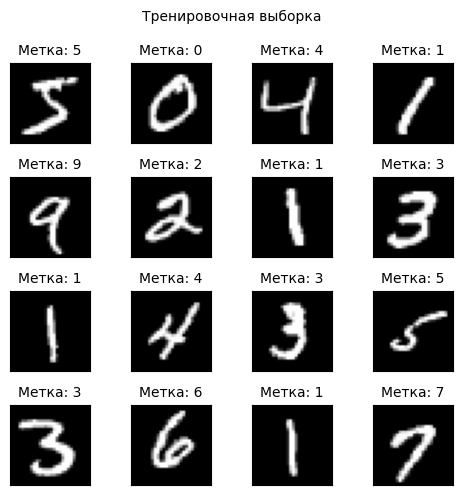

In [57]:
display_images(title= 'Тренировочная выборка', images=full_data[0], labels=full_data[2], grid_size=4)

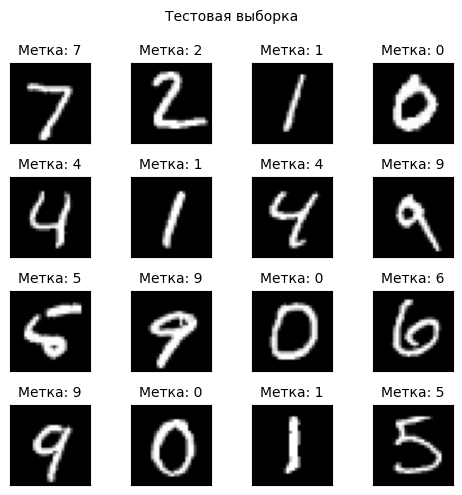

In [58]:
display_images(title= 'Тестовая выборка', images=full_data[1], labels=full_data[3], grid_size=4)

In [59]:
class MnistNeuralNetModel:
    def __init__(self, input_width, input_height, output_classes, hidden_neurons, lr=0.1):
        # Инициализация параметров
        self.input_width = input_width  
        self.input_height = input_height  
        self.output_classes = output_classes  
        self.hidden_neurons = hidden_neurons  
        self.lr = lr 
        
        # Инициализация весов и смещений для слоев
        self.weights_input_hidden = np.random.randn(input_width * input_height, hidden_neurons) * 0.01  # Веса для входа -> скрытый слой
        self.bias_hidden = np.zeros((1, hidden_neurons))  # Смещения для скрытого слоя
        self.weights_hidden_output = np.random.randn(hidden_neurons, output_classes) * 0.01  # Веса для скрытого сл -> выходной слой
        self.bias_output = np.zeros((1, output_classes))  # Смещения для выходного слоя

    # Активационная функция ReLU для скрытого слоя
    def relu_activation(self, input_data):
        return np.maximum(0, input_data)

    # Производная функции ReLU для обратного распространения ошибки
    def relu_derivative(self, input_data):
        return (input_data > 0).astype(float)

    # Функция softmax для выхода модели
    def softmax(self, logits):
        exp_vals = np.exp(logits - np.max(logits, axis=1, keepdims=True)) 
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    # Функция потерь - кросс-энтропия
    def compute_loss(self, true_labels, predicted_probs):
        sample_size = true_labels.shape[0]
        return -np.sum(true_labels * np.log(predicted_probs + 1e-15)) / sample_size  # Добавляем малое значение для стабильности

    # Прямое распространение
    def forward_pass(self, inputs):
        # Входной слой -> скрытый слой
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.relu_activation(self.hidden_layer_input)  
        # Скрытый слой -> выходной слой
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_probs = self.softmax(self.output_layer_input) 
        return self.output_probs

    # Обратное распространение
    def backward_pass(self, inputs, true_labels, predicted_probs):
        sample_size = true_labels.shape[0]

        # Градиенты для выходного слоя
        d_output_layer_input = predicted_probs - true_labels  
        d_weights_hidden_output = np.dot(self.hidden_layer_output.T, d_output_layer_input) / sample_size  
        d_bias_output = np.sum(d_output_layer_input, axis=0, keepdims=True) / sample_size  

        # Градиенты для скрытого слоя
        d_hidden_layer_output = np.dot(d_output_layer_input, self.weights_hidden_output.T)
        d_hidden_layer_input = d_hidden_layer_output * self.relu_derivative(self.hidden_layer_input) 
        d_weights_input_hidden = np.dot(inputs.T, d_hidden_layer_input) / sample_size  
        d_bias_hidden = np.sum(d_hidden_layer_input, axis=0, keepdims=True) / sample_size 

        # Обновление весов и смещений
        self.weights_input_hidden -= self.lr * d_weights_input_hidden
        self.bias_hidden -= self.lr * d_bias_hidden
        self.weights_hidden_output -= self.lr * d_weights_hidden_output
        self.bias_output -= self.lr * d_bias_output

    def train_model(self, training_data, training_labels, batch_size=32, num_epochs=20):
        for epoch in range(num_epochs):
            start_time = time.time()
            for batch_start in range(0, len(training_data), batch_size):
                # Формирование мини-батчей
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]
                predictions = self.forward_pass(batch_data)
                loss = self.compute_loss(batch_labels, predictions)
                self.backward_pass(batch_data, batch_labels, predictions)

            epoch_duration = time.time() - start_time
            print(f'Эпоха {epoch + 1}, Ошибка: {loss:.4f}, Время: {epoch_duration:.2f} s')


# Подготовка данных: нормализация изображений и преобразование меток
X_train_reshaped = full_data[0].reshape(-1, full_data[0].shape[1] * full_data[0].shape[2])  
X_train_normalized = X_train_reshaped / 255  
y_train_one_hot = np.eye(10)[full_data[2]] 

# Инициализация и обучение модели
neural_net = MnistNeuralNetModel(input_width=28, input_height=28, output_classes=10, hidden_neurons=300)
neural_net.train_model(X_train_normalized, y_train_one_hot, batch_size=64, num_epochs=20)


Эпоха 1, Ошибка: 0.1194, Время: 2.63 s
Эпоха 2, Ошибка: 0.0612, Время: 2.52 s
Эпоха 3, Ошибка: 0.0429, Время: 2.52 s
Эпоха 4, Ошибка: 0.0356, Время: 2.59 s
Эпоха 5, Ошибка: 0.0317, Время: 2.65 s
Эпоха 6, Ошибка: 0.0290, Время: 2.35 s
Эпоха 7, Ошибка: 0.0283, Время: 2.50 s
Эпоха 8, Ошибка: 0.0262, Время: 2.47 s
Эпоха 9, Ошибка: 0.0237, Время: 2.45 s
Эпоха 10, Ошибка: 0.0221, Время: 2.53 s
Эпоха 11, Ошибка: 0.0198, Время: 2.43 s
Эпоха 12, Ошибка: 0.0171, Время: 2.35 s
Эпоха 13, Ошибка: 0.0146, Время: 2.24 s
Эпоха 14, Ошибка: 0.0120, Время: 2.16 s
Эпоха 15, Ошибка: 0.0104, Время: 2.28 s
Эпоха 16, Ошибка: 0.0097, Время: 2.18 s
Эпоха 17, Ошибка: 0.0080, Время: 2.15 s
Эпоха 18, Ошибка: 0.0076, Время: 2.18 s
Эпоха 19, Ошибка: 0.0065, Время: 2.22 s
Эпоха 20, Ошибка: 0.0057, Время: 2.18 s


In [61]:
X_test_reshaped = full_data[1].reshape(-1, full_data[1].shape[1] * full_data[1].shape[2])  
X_test_normalized = X_test_reshaped / 255  
y_test_one_hot = np.eye(10)[full_data[3]]

test_predictions = neural_net.forward_pass(X_test_normalized)
predicted_classes = np.argmax(test_predictions, axis=1)  
true_classes = np.argmax(y_test_one_hot, axis=1)  

accuracy = np.mean(predicted_classes == true_classes) * 100  
print(f"Точность на тестовой выборке: {accuracy:.2f}%")


Точность на тестовой выборке: 97.87%
